
# <p style="text-align: center;">MIS 382: Advanced Predictive Modeling</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 60</p>
## <p style="text-align: center;">Due: Wednesday, October 25th, submitted via Canvas by 11:59 pm</p>

### Siqi Chen (sc56839),   Korawat Tanwisuth (kt22354)

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+8+2=15pts)

In this question you will implement vanilla SGD and an adaptive gradient update technique called Adagrad. In addition, you will also implement ridge regularization. 

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.
2. Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD' or 'adagrad' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 10 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (10 epochs) for the best 2 combinations of learning_rate and regularization for both SGD and Adagrad. ie you should have 2 plots of MSE and parameter updates for SGD and adagrad each. Report the MSE at the end of 10 epochs for all 4 combinations.
3. Based on the experiments, answer the following:

1. Which of the 2 techniqes allows for larger initial setting of the learning_rate? Why?
2. What would a drawback of adagrad be? How could this be fixed? (Hint: Adadelta)

### 1.

Assume cost function is sum of squared error, then 

\begin{align}
E(\vec{w}) &= (t_{i} - y_{i})^2 \\
&= (t_{i} - w_{0} - w_{1}*x_{i1} - w_{2}*x_{i1}*x_{i2} - w_{3}*x_{i2})^2\\
\end{align}

Then we can calculate the gradient of cost function with respect to the weights,

\begin{align}
&\frac{\partial E(\vec{w}) }{\partial w_{0}} = -2(t_{i} - y_{i}) \\
&\frac{\partial E(\vec{w}) }{\partial w_{1}} = -2x_{i1}(t_{i} - y_{i}) \\
&\frac{\partial E(\vec{w}) }{\partial w_{2}} = -2x_{i1}x_{i2}(t_{i} - y_{i}) \\
&\frac{\partial E(\vec{w}) }{\partial w_{3}} = -2x_{i2}(t_{i} - y_{i}) \\
\end{align}

Let learning rate be $\eta$, the weight updates will then be,

\begin{align}
&w_{0}^{\tau + 1} = w_{0}^{\tau} + 2\eta(t_{i} - y_{i}) \\
&w_{1}^{\tau + 1} = w_{1}^{\tau} + 2\eta x_{i1}(t_{i} - y_{i}) \\
&w_{2}^{\tau + 1} = w_{2}^{\tau} + 2\eta x_{i1}x_{i2}(t_{i} - y_{i}) \\
&w_{3}^{\tau + 1} = w_{3}^{\tau} + 2\eta x_{i2}(t_{i} - y_{i}) \\
\end{align}

### 2.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
%pylab inline

samples = np.array(pd.read_csv('samples.csv',usecols=[1,2,3]))
x,y = samples[:,1:],samples[:,0]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import mean_squared_error
class SGD:
    def __init__(self, learning_rate, reg, nb_epochs, params_init = None):
        self.learning_rate = learning_rate
        self.reg = reg
        self.nb_epochs = nb_epochs
        if params_init is not None:
            self.params = np.array(params_init)
        else:
            self.params = np.zeros(4)

    def fit(self, x, y, update_rule = 'SGD'):
        def evaluate_gradient(data, params, reg):
            t, x1, x2 = data
            w0, w1, w2, w3 = params
            g0 = 2*(w0 + w1*x1 + w2*x1*x2 + w3*x2 - t) + 2*reg*w0
            g1 = 2*x1*(w0 + w1*x1 + w2*x1*x2 + w3*x2 - t) + 2*reg*w1
            g2 = 2*x1*x2*(w0 + w1*x1 + w2*x1*x2 + w3*x2 - t) + 2*reg*w2
            g3 = 2*x2*(w0 + w1*x1 + w2*x1*x2 + w3*x2 - t) + 2*reg*w3
            return np.array([g0,g1,g2,g3])        
        self.w = []
        self.mse = []
        n = x.shape[0]
        x1 = x[:,0]
        x2 = x[:,1]
        data = np.column_stack((y,x))
        cache = np.zeros(4)
        for i in range(self.nb_epochs):
            np.random.shuffle(data)       
            for d in data:
                params_grad = evaluate_gradient(d, self.params, self.reg)
                if update_rule == 'adagrad':
                    cache += params_grad**2
                    self.params = self.params - self.learning_rate/np.sqrt(cache + 1e-6) * params_grad
                else:
                    self.params = self.params - self.learning_rate * params_grad
            predict = self.params[0] * np.ones(n) + self.params[1]*x1 + self.params[2]*x1*x2 + self.params[3]*x2
            self.w.append(self.params)
            self.mse.append(mean_squared_error(y,predict))
            
    def predict(self, x):
        x1 = x[:,0]
        x2 = x[:,1]
        n = x.shape[0]
        predict = self.params[0] * np.ones(n) + self.params[1]*x1 + self.params[2]*x1*x2 + self.params[3]*x2
        return predict

In [3]:
lr = [.0001, .001, .01, 0.1, 1, 10, 100]
reg = [0,10,100]

MSE_sgd = []
MSE_adagrad = []
for l in lr:
    for r in reg:
        try:
            gd = SGD(l,r,10)
            gd.fit(x,y,update_rule = 'SGD')
            MSE_sgd.append((l,r,gd.mse[-1]))
        except:
            MSE_sgd.append((l,r,99999))
        try:
            gd = SGD(l,r,10)
            gd.fit(x,y,update_rule = 'adagrad')
            MSE_adagrad.append((l,r,gd.mse[-1]))
        except:
            MSE_adagrad.append((l,r,99999))

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python2.7/site-packages/ipykernel_la

In [4]:
MSE_sgd.sort(key = lambda x: x[2])
MSE_adagrad.sort(key = lambda x: x[2])

In [5]:
print '1st best combination for sgd: learning rate = {}, regularization = {}, MSE = {}'.format(MSE_sgd[0][0],MSE_sgd[0][1],MSE_sgd[0][2])
print '2nd best combination for sgd: learning rate = {}, regularization = {}, MSE = {}'.format(MSE_sgd[1][0],MSE_sgd[1][1],MSE_sgd[1][2])
print '1st best combination for adagrad: learning rate = {}, regularization = {}, MSE = {}'.format(MSE_adagrad[0][0],MSE_adagrad[0][1],MSE_adagrad[0][2])
print '2nd best combination for adagrad: learning rate = {}, regularization = {}, MSE = {}'.format(MSE_adagrad[1][0],MSE_adagrad[1][1],MSE_adagrad[1][2])

1st best combination for sgd: learning rate = 0.001, regularization = 0, MSE = 3.1143152625e-13
2nd best combination for sgd: learning rate = 0.0001, regularization = 0, MSE = 0.132290242551
1st best combination for adagrad: learning rate = 1, regularization = 0, MSE = 3.89271565165e-21
2nd best combination for adagrad: learning rate = 100, regularization = 0, MSE = 4.33056376117e-21


In [6]:
best_sgd = [(MSE_sgd[0][0],MSE_sgd[0][1]),(MSE_sgd[1][0],MSE_sgd[1][1])]
best_adagrad = [(MSE_adagrad[0][0],MSE_adagrad[0][1]),(MSE_adagrad[1][0],MSE_adagrad[1][1])]

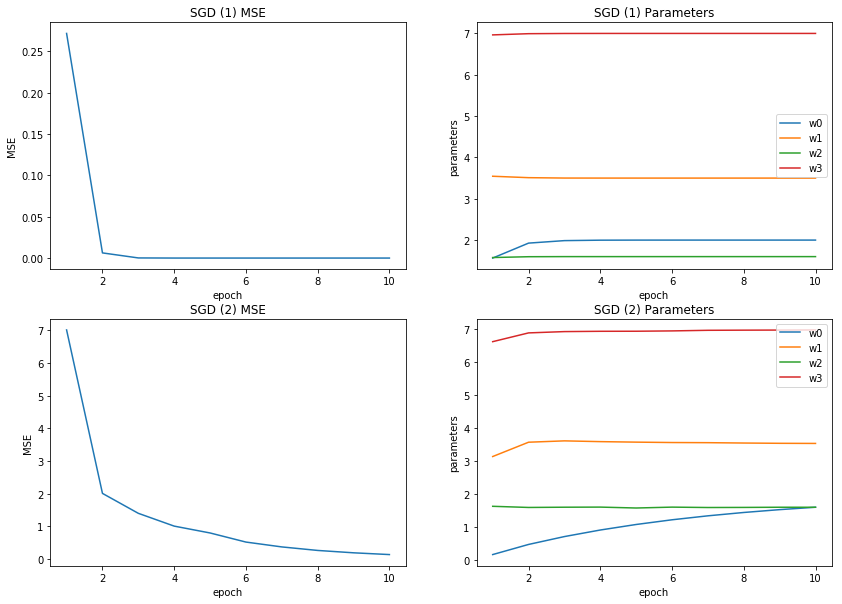

In [7]:
fig, ((ax1,ax2),(ax3,ax4)) = subplots(2,2,figsize = (14,10))
ax = [ax1,ax2,ax3,ax4]
epoch = range(1,11)
for (i,(lr,reg)) in enumerate(best_sgd):
    gd = SGD(lr,reg,10)
    gd.fit(x,y,update_rule = 'SGD')
    mse = gd.mse
    w0,w1,w2,w3 = zip(*gd.w)
    ax[2*i].plot(epoch,mse,label='MSE')
    ax[2*i].set_title('SGD ({}) MSE'.format(i+1))
    ax[2*i].set_xlabel('epoch')
    ax[2*i].set_ylabel('MSE')
    ax[2*i+1].plot(epoch,w0,label='w0')
    ax[2*i+1].plot(epoch,w1,label='w1')
    ax[2*i+1].plot(epoch,w2,label='w2')
    ax[2*i+1].plot(epoch,w3,label='w3')
    ax[2*i+1].set_title('SGD ({}) Parameters'.format(i+1))
    ax[2*i+1].set_xlabel('epoch')
    ax[2*i+1].set_ylabel('parameters')
    ax[2*i+1].legend()

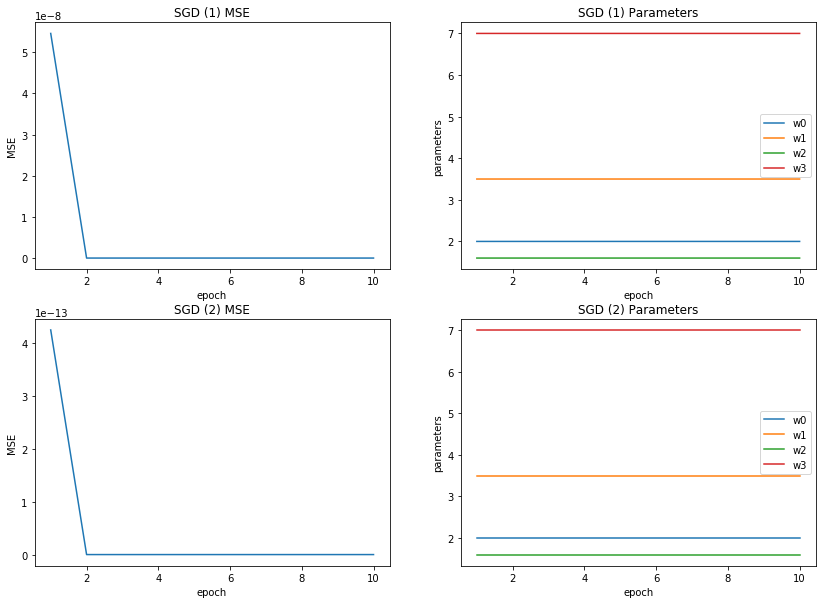

In [8]:
fig, ((ax1,ax2),(ax3,ax4)) = subplots(2,2,figsize = (14,10))
ax = [ax1,ax2,ax3,ax4]
epoch = range(1,11)
for (i,(lr,reg)) in enumerate(best_adagrad):
    gd = SGD(lr,reg,10)
    gd.fit(x,y,update_rule = 'adagrad')
    mse = gd.mse
    w0,w1,w2,w3 = zip(*gd.w)
    ax[2*i].plot(epoch,mse,label='MSE')
    ax[2*i].set_title('SGD ({}) MSE'.format(i+1))
    ax[2*i].set_xlabel('epoch')
    ax[2*i].set_ylabel('MSE')
    ax[2*i+1].plot(epoch,w0,label='w0')
    ax[2*i+1].plot(epoch,w1,label='w1')
    ax[2*i+1].plot(epoch,w2,label='w2')
    ax[2*i+1].plot(epoch,w3,label='w3')
    ax[2*i+1].set_title('SGD ({}) Parameters'.format(i+1))
    ax[2*i+1].set_xlabel('epoch')
    ax[2*i+1].set_ylabel('parameters')
    ax[2*i+1].legend()

### 3.

1. Adagrad allows for larger initial setting of learning rate, since its learning rate is adjusted by square root of cache (sum of gradients). Larger gradient will result in smaller learning rate, preventing overshooting.
2. The drawback of adagrad is that it accumulate the gradients over time and as training continues the learning rate will shrink and eventually become infinitesimally small, at which point the algorithm is not updating the weight. We could use adadelta to solve this problem, which allows only an window of period for accumulation of past gradients for weight shrinkage.

# Notes on Adagrad
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

### A.

i) 

200 epochs
- learning rate = 0.3, test loss = 0.014, training loss = 0.012
- learning rate = 0.01, test loss = 0.021, training loss = 0.020
- learning rate = 0.003, test loss = 0.030, training loss = 0.029

1000 epochs
- learning rate = 0.3, test loss = 0.012, training loss = 0.011
- learning rate = 0.01, test loss = 0.017, training loss = 0.016
- learning rate = 0.003, test loss = 0.022, training loss = 0.022

ii)
- 1 neuron: test loss = 0.042, training loss = 0.041, output is spliting up the data into two parts.

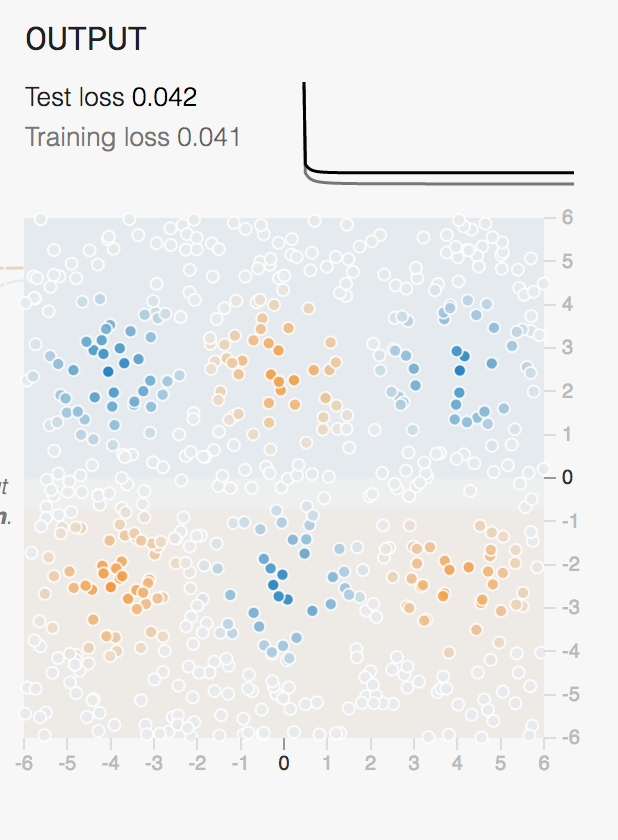

In [9]:
from IPython.display import Image
Image("1.png",embed = True, width = 300, height = 300)

- 2 neuron: test loss = 0.031, training loss = 0.030, output further splits up the data into four parts.

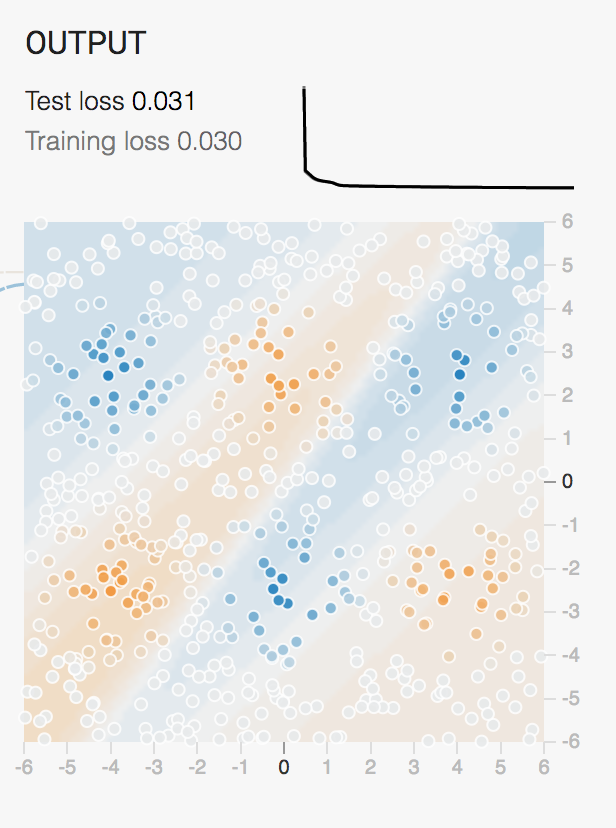

In [10]:
from IPython.display import Image
Image("2.png",embed = True, width = 300, height = 300)

- 3 neuron: test loss = 0.018, training loss = 0.018, output now splits up the data into six parts.

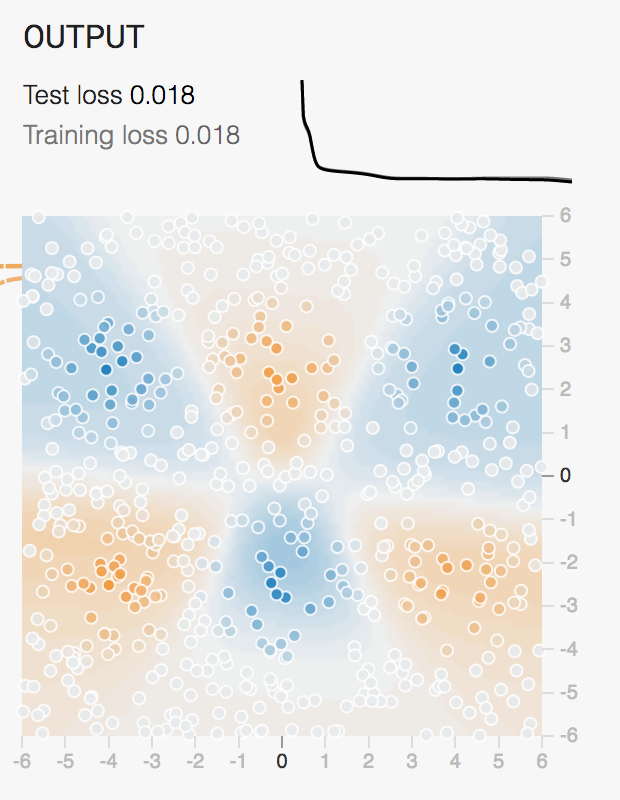

In [11]:
from IPython.display import Image
Image("3.png",embed = True, width = 300, height = 300)

- 8 neuron: test loss = 0.016, training loss = 0.016, output fits slightly improved comparing to 3 neurons.

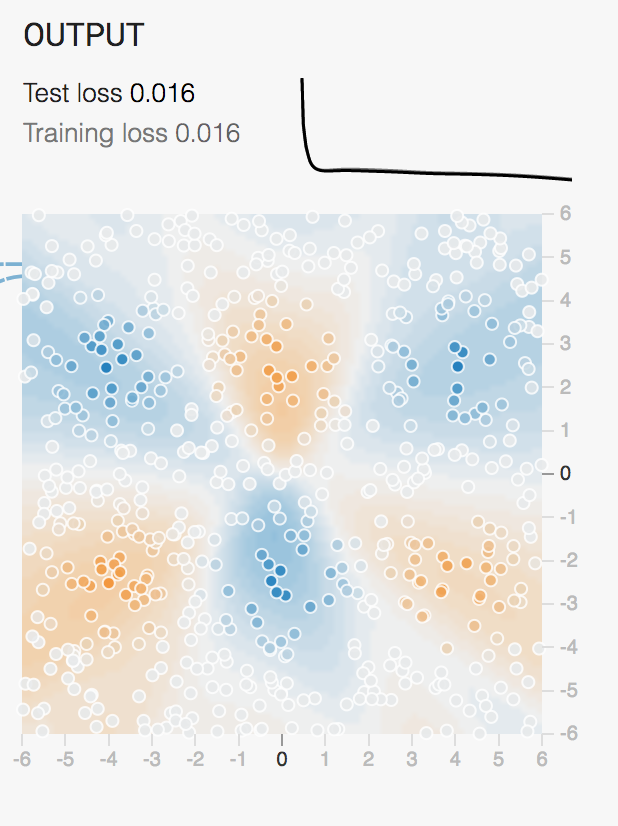

In [12]:
from IPython.display import Image
Image("8.png",embed = True, width = 300, height = 300)

iii)

- Sigmoid: test loss = 0.043, training loss = 0.043, output fits are linear, high test/training loss.

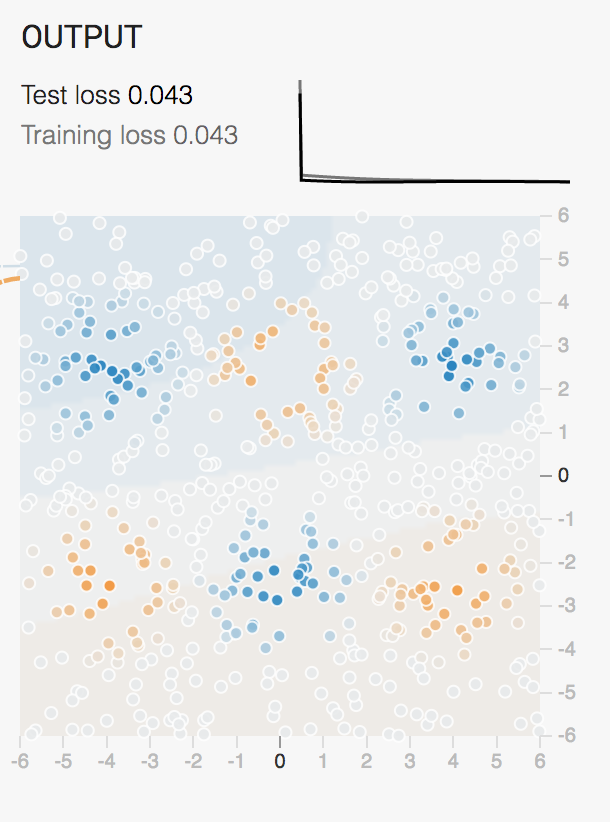

In [13]:
from IPython.display import Image
Image("sigmoid.png",embed = True, width = 300, height = 300)

- Linear: test loss = 0.044, training loss = 0.044, output fits are linear, high test/training loss as well.

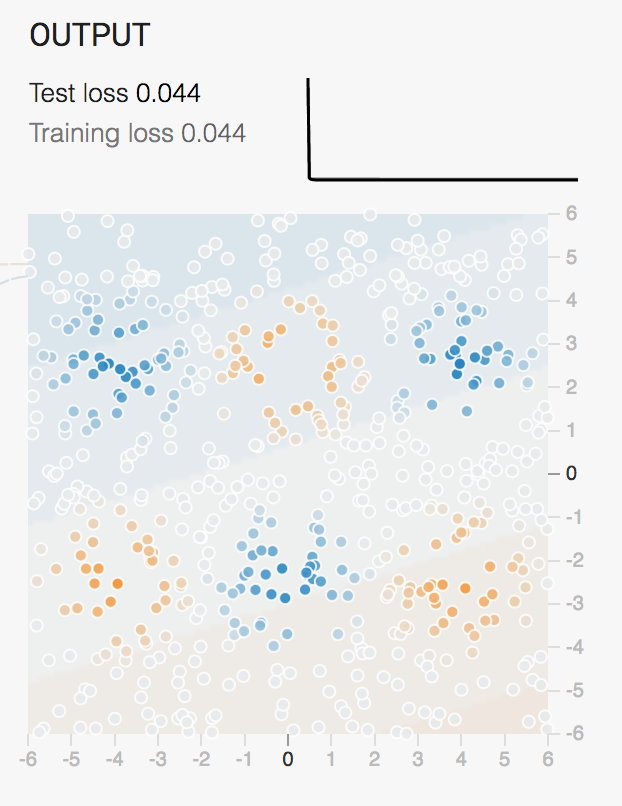

In [14]:
from IPython.display import Image
Image("linear.png",embed = True, width = 300, height = 300)

- Relu: test loss = 0.033, training loss = 0.036, output fits splits up the data into 3 parts, slightly better than linear activation function.

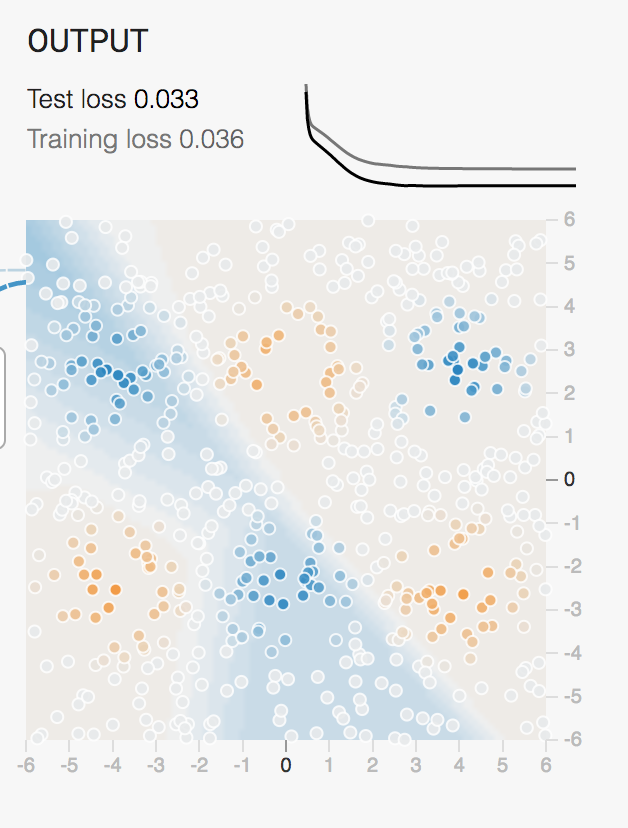

In [15]:
from IPython.display import Image
Image("relu.png",embed = True, width = 300, height = 300)

- Tanh: test loss = 0.021, training loss = 0.020, output fits splits up the data into six parts, low test/traing loss.

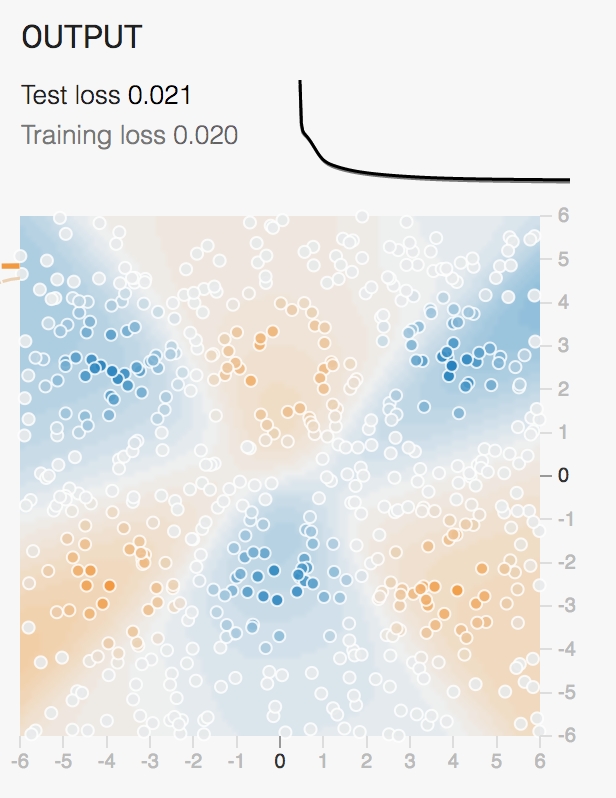

In [16]:
from IPython.display import Image
Image("tanh.png",embed = True, width = 300, height = 300)

### B.

- 2 inputs, almost no more information gain after reaching the optimal weights. Not enough information from 2 inputs.

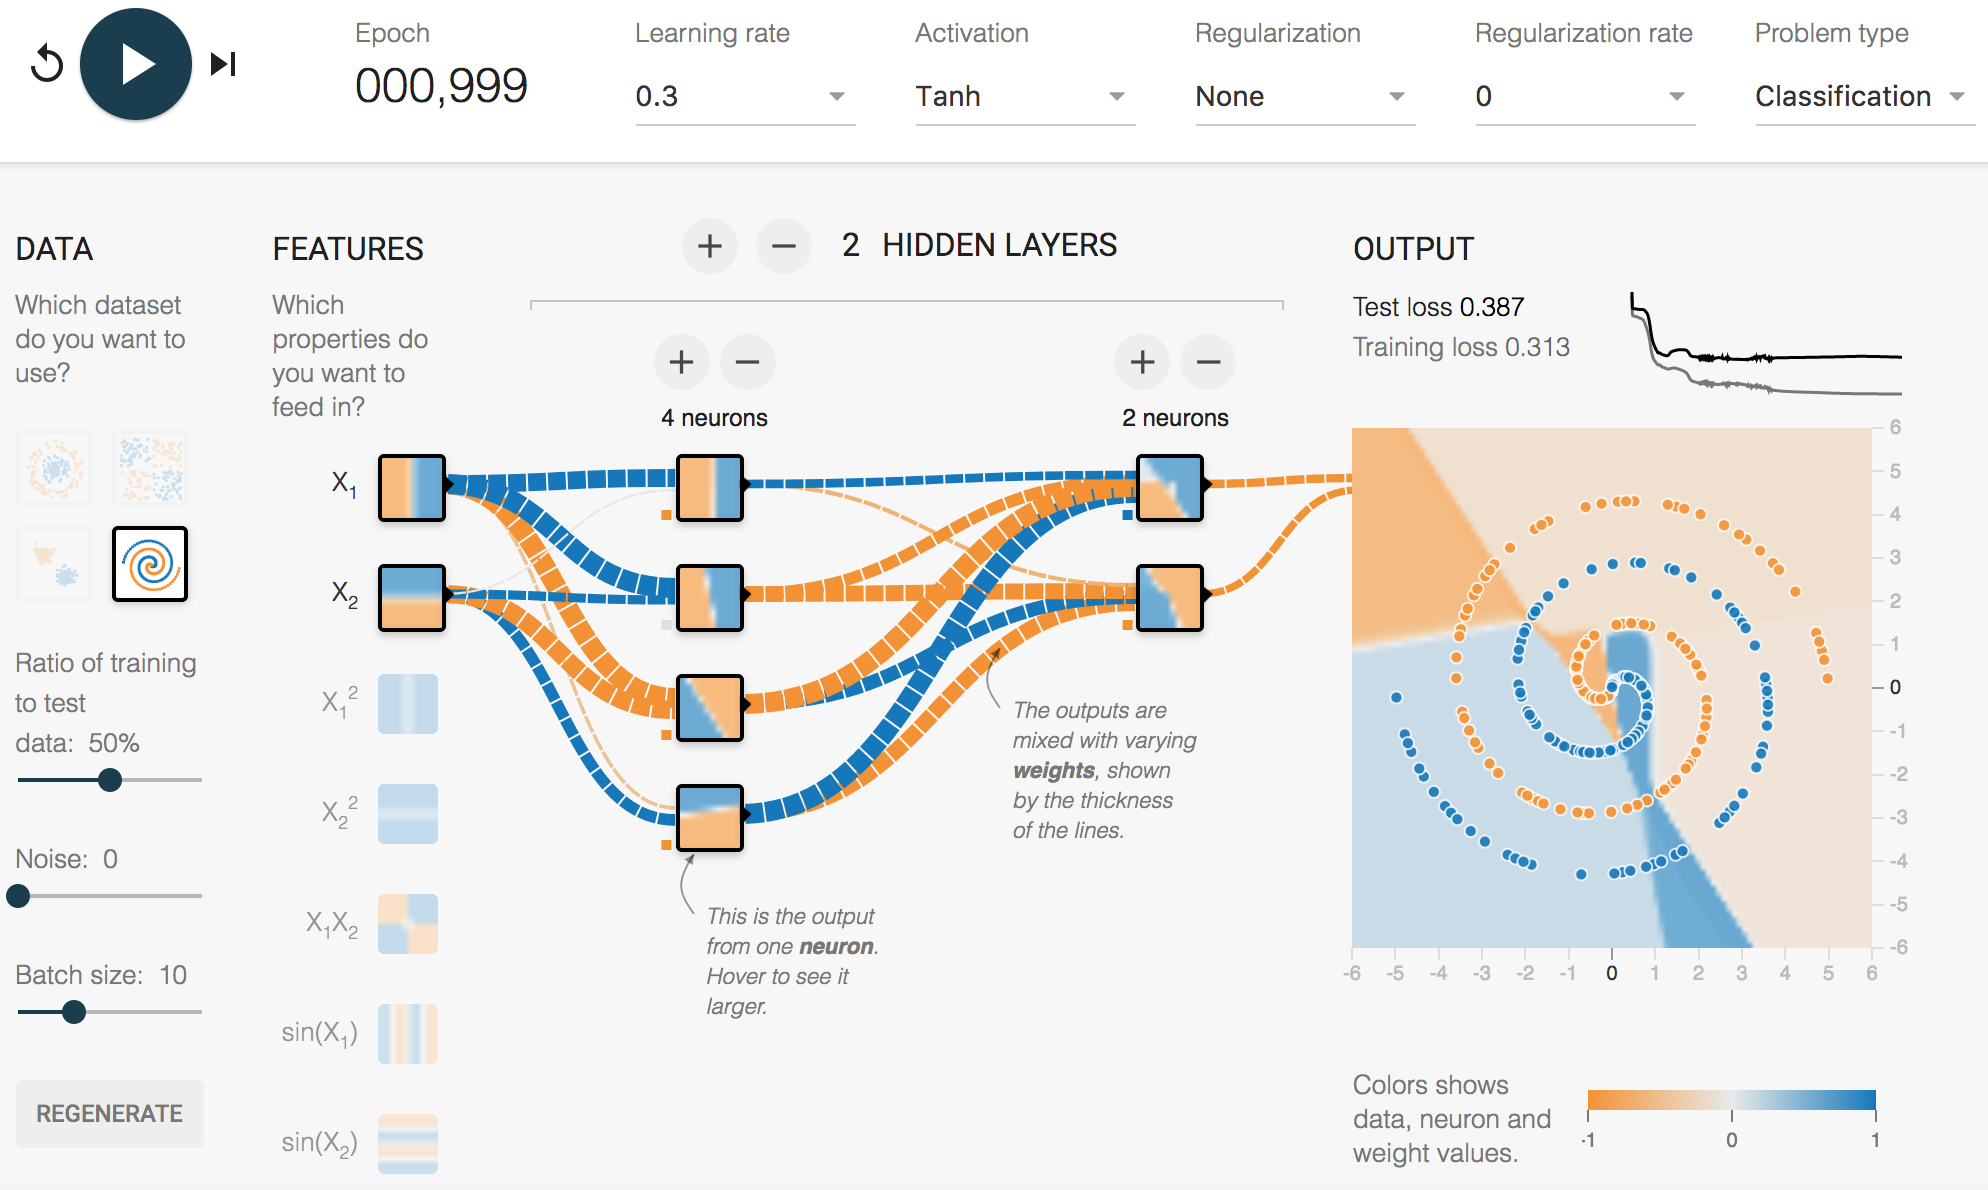

In [17]:
from IPython.display import Image
Image("2_input.png",embed = True, width = 800, height = 800)

- 7 inputs, it's important to control the learning rate when having high dimension of feature space. Lower learning rate can prevent overshooting. Information provided with 7 inputs fits the data much better than with 2 inputs.

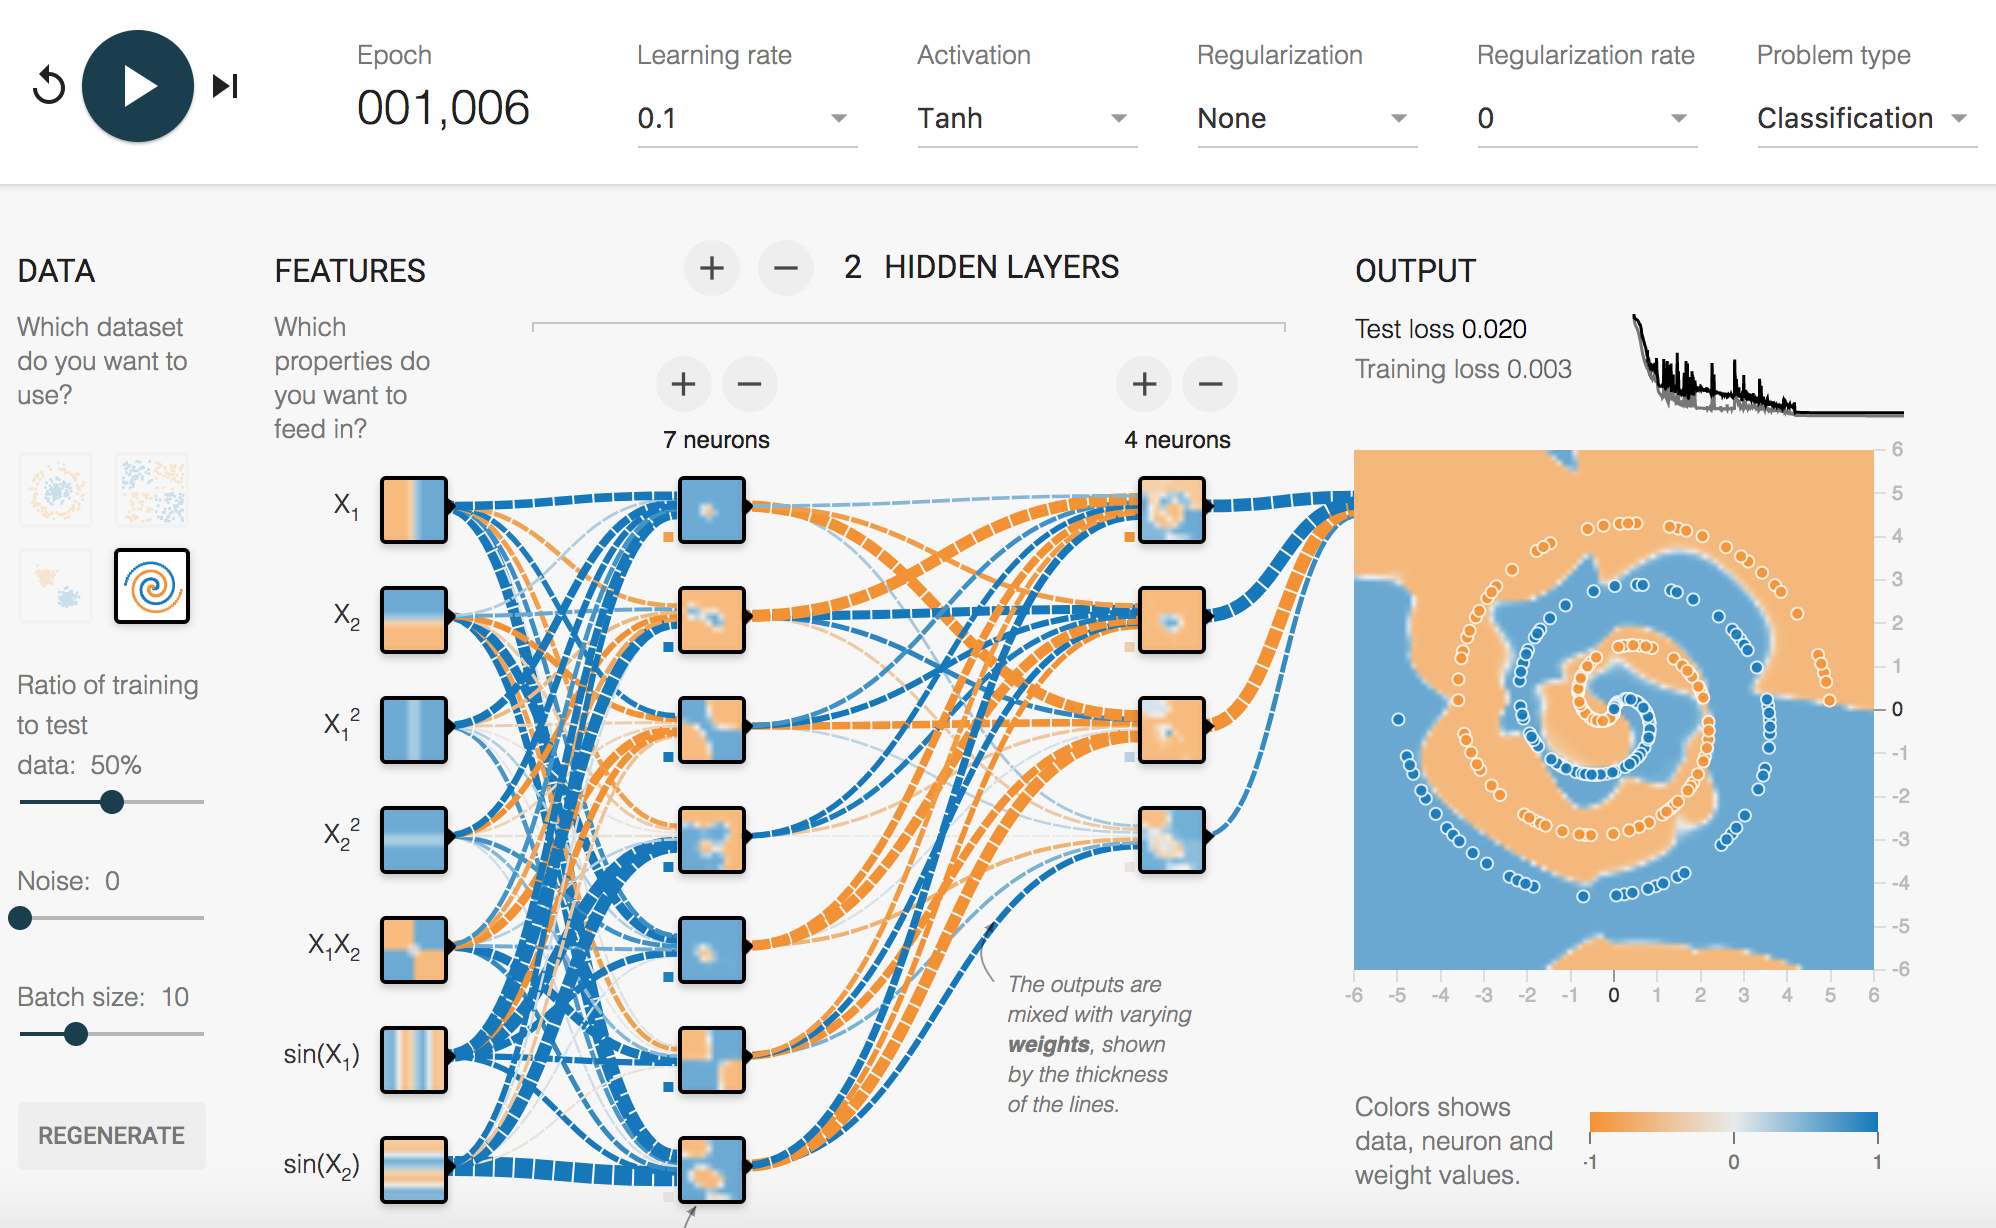

In [18]:
from IPython.display import Image
Image("7_input.png",embed = True, width = 800, height = 800)

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the Appliances energy prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.
Make sure you have 56 variables and one target variable.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

from sklearn import datasets

data = pd.read_csv('energydata_complete.csv') 

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in xrange(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((13222, 56), (13222,), (6513, 56), (6513,))


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider three different settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* (b) *hidden_layer_sizes = (30,10)* (c) *hidden_layer_sizes = (100,)*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (a), (b), and (c) (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best, (a), (b), or (c)? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, hidden_layer_sizes = (15,)
    
Now, consider three different settings for the learning rates:
    
   (i) *learning_rate_init = 0.005* (ii) *learning_rate_init = 0.01* (iii) *learning_rate_init = 1*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (i), (ii), and (iii) (5pts)




### 1)

In [20]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [21]:
hidden = [(2,),(30,10),(100,)]
kf = KFold(n_splits = 5)

for h in hidden:
    mlp = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init = 0.005, hidden_layer_sizes = h)
    scores = cross_val_score(mlp, X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error')    
    mean_score = np.sqrt(-scores).mean()
    print 'hidden layer size = {}, RMSE = {}'.format(h,mean_score)

hidden layer size = (2,), RMSE = 94.9362385743
hidden layer size = (30, 10), RMSE = 102.586729639
hidden layer size = (100,), RMSE = 81.6606039886


### 2）

In [22]:
for h in hidden:
    mlp = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init = 0.005, hidden_layer_sizes = h)
    mlp.fit(X_train,y_train)
    y_fit = mlp.predict(X_train)
    y_predict = mlp.predict(X_test)
    print 'hidden layer size = {}, train RMSE = {}, test RMSE = {}'.format(h,np.sqrt(mean_squared_error(y_train,y_fit)),np.sqrt(mean_squared_error(y_test,y_predict)))
                                                                           

hidden layer size = (2,), train RMSE = 92.4398639674, test RMSE = 93.1462304597
hidden layer size = (30, 10), train RMSE = 78.7766484402, test RMSE = 84.6817190796
hidden layer size = (100,), train RMSE = 67.7820561419, test RMSE = 80.5835014268


c) works the best, 100 hidden units fits the data better.

### 3）

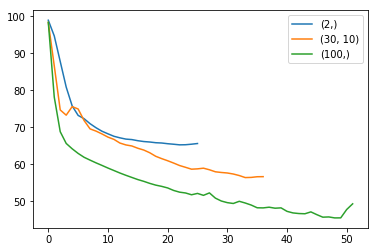

In [23]:
mlps = []
for h in hidden:
    mlp = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init = 0.005, hidden_layer_sizes = h)
    mlp.fit(X_train,y_train)
    mlps.append(mlp)

for mlp,h in zip(mlps,hidden):
    plt.plot(np.sqrt(mlp.loss_curve_), label = h)
plt.legend()

### 4)

In [24]:
lr = [0.005,0.01, 1]

for l in lr:
    mlp = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=5000, hidden_layer_sizes = (15,), learning_rate_init = l)
    scores = cross_val_score(mlp, X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error')    
    mean_score = np.sqrt(-scores).mean()
    print 'learning rate = {}, RMSE = {}'.format(l,mean_score)

learning rate = 0.005, RMSE = 88.3324646365
learning rate = 0.01, RMSE = 90.3531300757
learning rate = 1, RMSE = 66247441756.3


# Question 4: (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 30 respectively and that of those who don’t is 8.5 and 25. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now write code to sample 100 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER

### a.

The class conditional likelihood is the likelihood of an input given that the input belong to the class. Class prior reflects 
the likelihood of a value for a random variable representing the state of nature of an input in the absence of other  information. Posterior probability is the probability that an input belongs to a class given that input.<br>
<br>
X-Random variable of an input<br>
C-Random variable of a class
$$ Posterior\;Probability = \frac{Class-Conditional\;likelihood*Class\;Priors}{Input\;likelihood}$$
$$ P(C|X) = (\frac{P(X|C)*P(C)}{P(X)}) $$

### b.

To find the decision boundary, we need to determine when 

\begin{align}
P(C=1\mid x_{1},x_{2}) &= P(C=0\mid x_{1},x_{2}) \\
\Leftrightarrow \quad \frac{p(x_{1},x_{2}\mid C=1)P(C=1)}{p(x_{1},x_{2})} &= \frac{p(x_{1},x_{2}\mid C=0)P(C=0)}{p(x_{1},x_{2})} \\ 
\Leftrightarrow \quad p(x_{1},x_{2}\mid C=1)P(C=1) &= p(x_{1},x_{2}\mid C=0)P(C=0)\\ 
\Leftrightarrow \quad \ln p(x_{1},x_{2}\mid C=1) + \ln P(C=1) &= \ln p(x_{1},x_{2}\mid C=0) + \ln P(C=0)\\ 
\end{align}

It's given that in the past few years, only 1 in 3 people bought a TV, therefore, 
\begin{align}
P(C=1) &= \frac{1}{3}\\
P(C=0) &= \frac{2}{3}\\
\end{align}

Also, since class conditional distribution is Gaussian with same covariance given by Identity matrix,
\begin{align}
p(x_{1},x_{2}\mid C) = exp(-\frac{\lVert \boldsymbol{x}  - \boldsymbol{\mu}  \rVert^2}{2\sigma^2} + constant)
\end{align}

Hence,
\begin{align}
-\frac{\lVert \boldsymbol{x}  - \boldsymbol{\mu_{1}}  \rVert^2}{2\sigma^2} +  \ln \frac{1}{3} &= -\frac{\lVert \boldsymbol{x}  - \boldsymbol{\mu_{0}}  \rVert^2}{2\sigma^2} + \ln \frac{2}{3}\\ 
\Leftrightarrow \quad -\frac{1}{2}(x_{1}^2 + x_{2}^2 -2(15x_{1} + 30x_{2})+15^2 + 30^2) +  \ln \frac{1}{3} &= -\frac{1}{2}(x_{1}^2 + x_{2}^2-2(8.5x_{1} + 25x_{2})+8.5^2 + 25^2) + \ln \frac{2}{3}\\
\Leftrightarrow \quad 15x_{1}+30x_{2} - 562.5 +  \ln \frac{1}{3} &= 8.5x_{1}+25x_{2} - 697.25+ \ln \frac{2}{3}\\ 
\Leftrightarrow \quad 13x_{1} + 10x_{2} &= 429.14\\ 
\end{align}


### c.

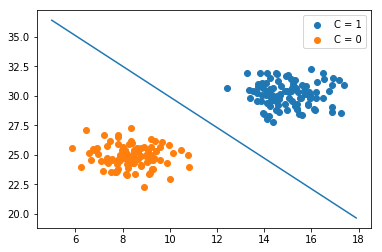

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.naive_bayes import GaussianNB

np.random.seed(0)
mu1 = [15, 30]
cov1 = np.eye(2)

mu2 = [8.5, 25]
cov2 = np.eye(2)

X = np.concatenate([np.random.multivariate_normal(mu1, cov1, 100),
                    np.random.multivariate_normal(mu2, cov2, 100)])
y = np.zeros(200)
y[:100] = 1

t1 = np.arange(5, 18, 0.1)
t2 = 214.57/5 - 6.5/5*t1

plt.scatter(X[:100, 0], X[:100, 1])
plt.scatter(X[100:, 0], X[100:, 1])
plt.legend(('C = 1','C = 0'))
plt.plot(t1,t2,'-')


# Question 5: Decision Tree using Python (10 pts)
In this problem, you will model the data using decision trees to perform a classification task. Load the BreastTissue.csv dataset. The dataset has been preprocessed. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Tissue). Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use all the data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [26]:
from sklearn import tree
from sklearn.externals.six import StringIO

breast = pd.read_csv('BreastTissue.csv', index_col= 0)
X,y = breast.loc[:,'I0':'P'],breast['Class']

In [27]:
clf_gini = tree.DecisionTreeClassifier(criterion='gini',max_depth=2)
clf_gini.fit(X,y)
tree.export_graphviz(clf_gini, out_file='tree_gini.dot') 

In [28]:
clf_entropy = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
clf_entropy.fit(X,y)
tree.export_graphviz(clf_entropy, out_file='tree_entropy.dot') 

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?

#### Gini Tree

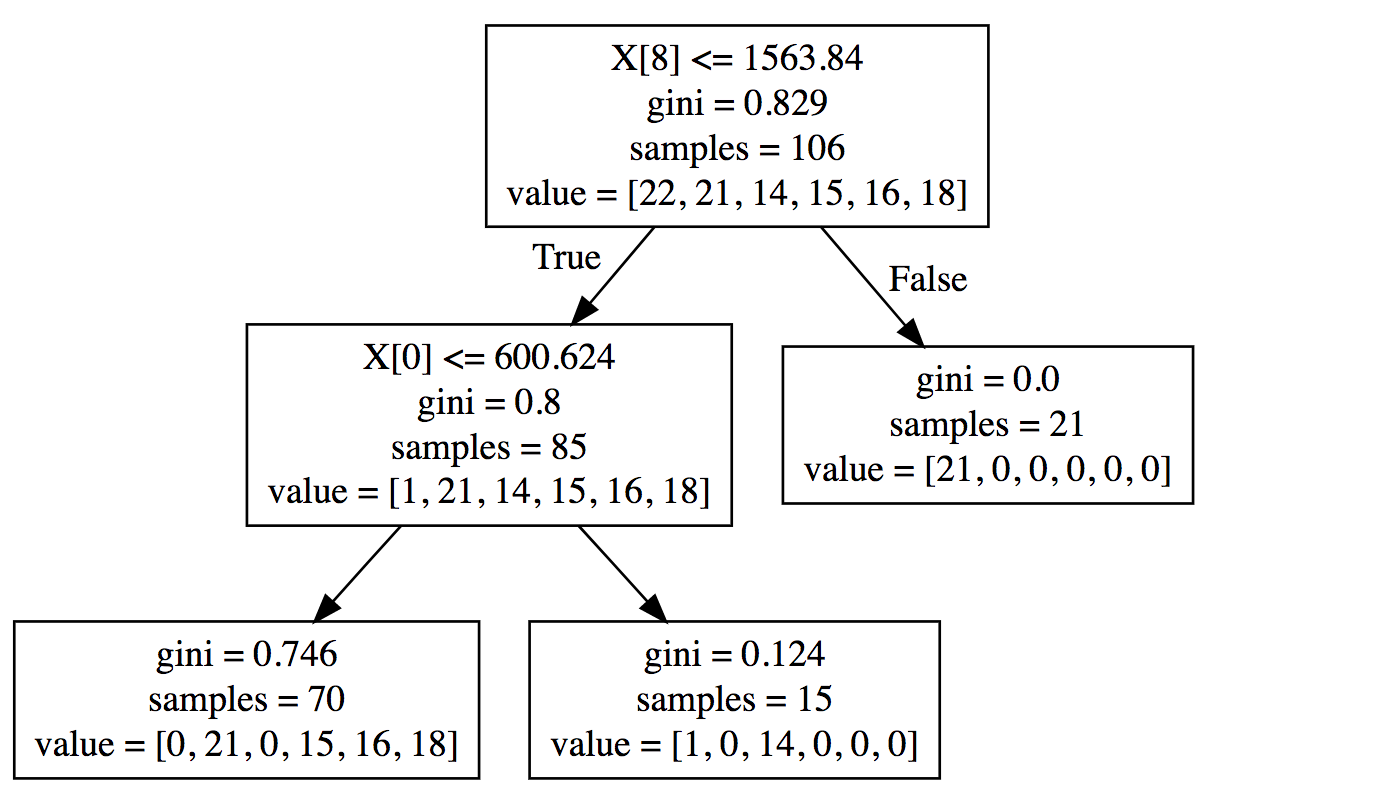

In [29]:
from IPython.display import Image
Image("tree_gini.png", embed = True, width = 400, height = 400)

#### Entropy Tree

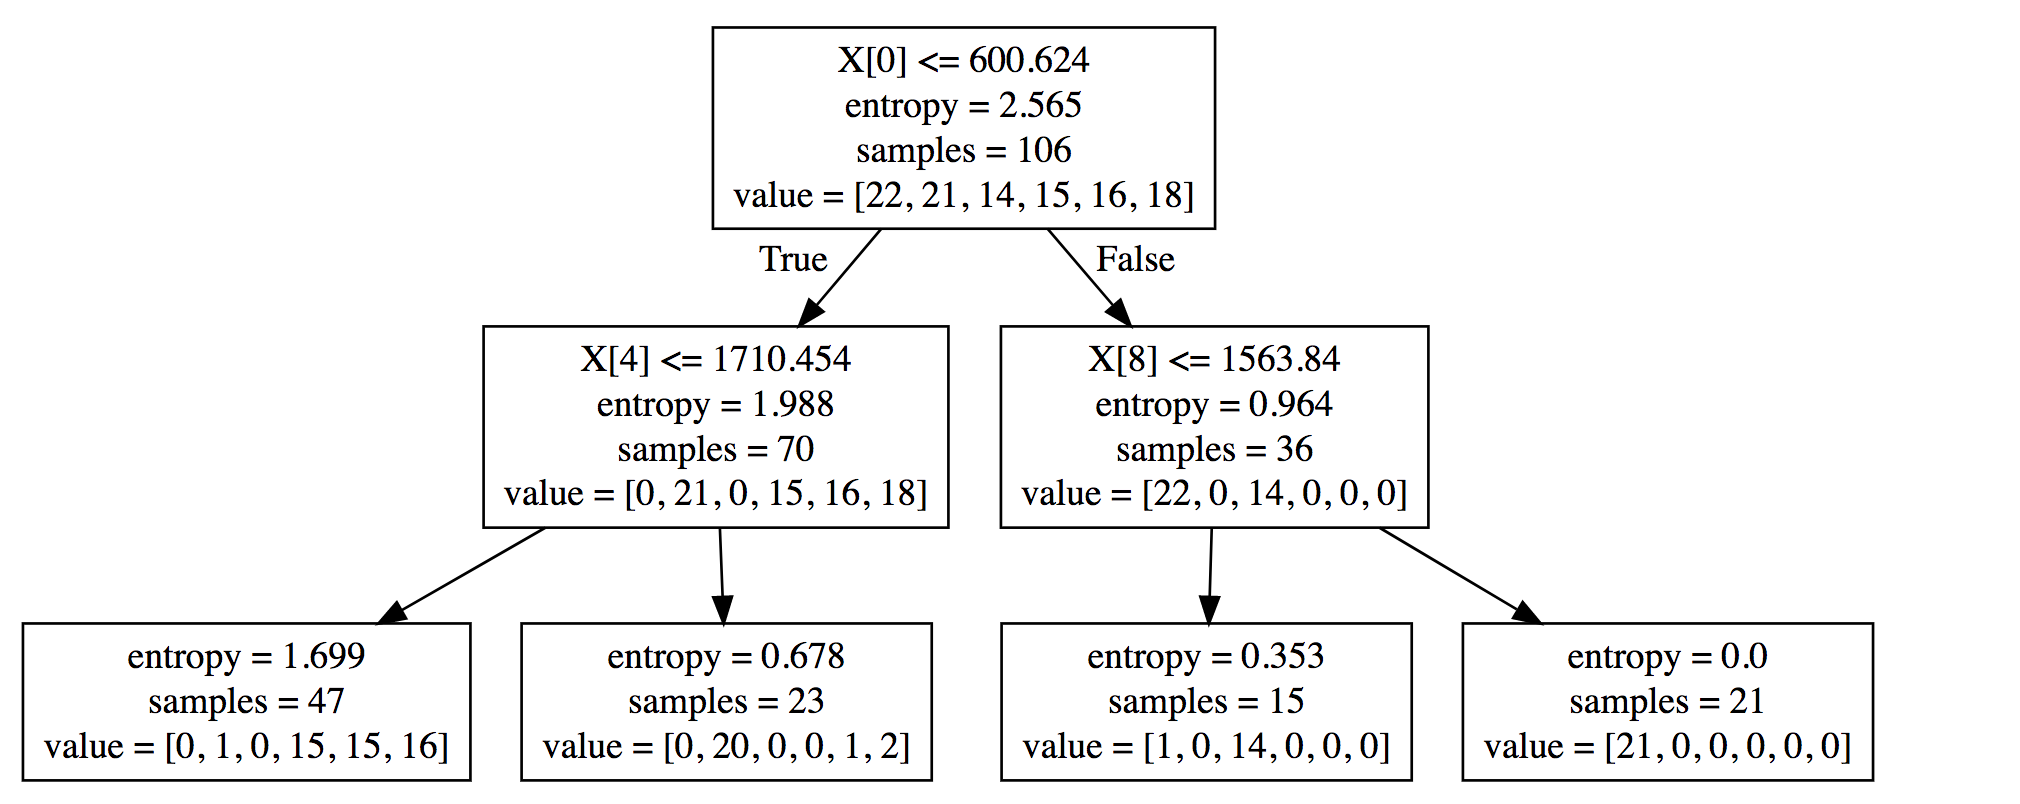

In [30]:
from IPython.display import Image
Image("tree_entropy.png", embed = True, width = 600, height = 600)

From the beginning, the two metrics do not consider the same nodes. We can see that gini index uses X[8] to make the first cut while entropy uses X[0], meaning that X[8] was a better cut for gini index and vice versa. However, gini index later considers X[0] and make the final cut there while entropy also look at X[4] and X[8]. The additional cut leads to a more balanced number of samples in the terminal node for entropy. This means that even though we are fitting the same algorithm, the cutoff criterion can heavily influence the final outcomes of our model as seen in this example.